In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()


from spike_statistics.core import permutation_resampling_test, block_bootstrap

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

15:46:03 [I] klustakwik KlustaKwik2 version 0.2.6


## chose where to sample LFP

In [3]:
#################################################

# lfp_location = ''
# lfp_location = '-other-tetrode'
lfp_location = '-other-drive'

##################################################

In [4]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("stimulus-spike-lfp-response" + lfp_location)
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [5]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [6]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [7]:
lfp_action = actions['stimulus-spike-lfp-response' + lfp_location]
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [8]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
lfp_results = lfp_results.drop('unit_id', axis=1)

In [9]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [10]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
# stim_results = stim_results.drop('unit_id', axis=1)

In [11]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [12]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [13]:
data = data.merge(lfp_results, how='left')

In [14]:
data = data.merge(stim_results, how='left')

In [15]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [16]:
data = data.merge(waveform_results, how='left')

In [17]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [18]:
data.bs = data.bs.astype(bool)

In [19]:
data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

In [20]:
# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [21]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [22]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 230
Number of animals 4


In [23]:
gridcell_sessions

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,t_i_peak,p_i_peak,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited
14,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0087,0.000055,0.259757,0.362390,0.180529,False,0.0,NaN,True,False
21,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0008,0.000880,0.242524,0.534827,2.265039,True,1.0,NaN,False,False
29,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,NaN,0.279806,0.598967,10.924422,True,1.0,NaN,False,False
30,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0005,0.002365,0.265158,0.581451,3.984881,True,1.0,NaN,False,False
31,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,NaN,0.246920,0.570844,3.497452,True,1.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.280033,0.560729,4.760330,True,1.0,NaN,False,False
1264,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.281934,0.627089,15.890929,True,1.0,NaN,False,False
1268,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.266512,0.594033,2.704037,True,1.0,NaN,False,False
1271,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.223261,0.592553,9.658453,True,1.0,NaN,False,False


In [24]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(gridcell_sessions)

data.loc[data.eval('not gridcell and bs'), 'bs_not_gridcell'] = True
data.bs_not_gridcell.fillna(False, inplace=True)

In [25]:
data.query('baseline and Hz11 and gridcell').head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited,gridcell,bs_not_gridcell
33,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.272875,0.602667,5.945508,True,NaN,1.0,False,False,True,False
34,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.226452,0.274814,2.860048,False,NaN,0.0,False,True,True,False
35,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.247266,0.570104,3.365674,True,NaN,1.0,False,False,True,False
39,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.284542,0.644111,17.471520,True,NaN,1.0,False,False,True,False
40,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.259920,0.581698,5.891739,True,NaN,1.0,False,False,True,False


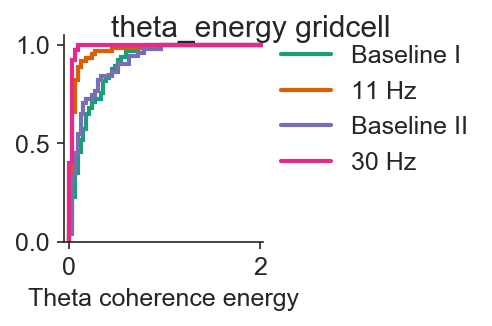

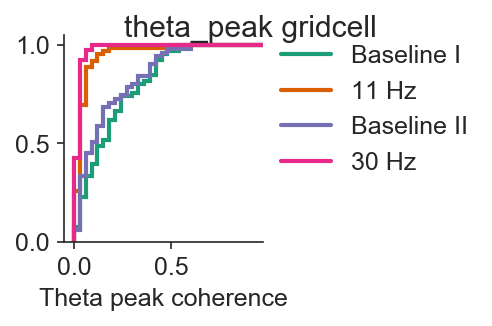

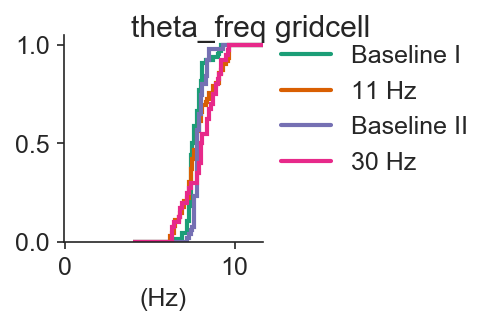

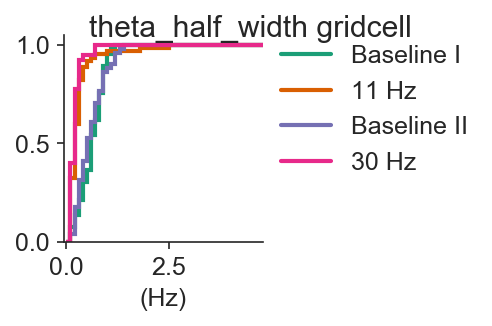

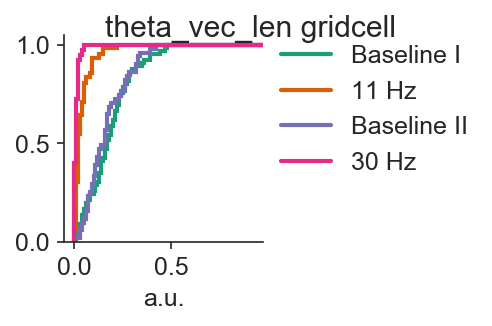

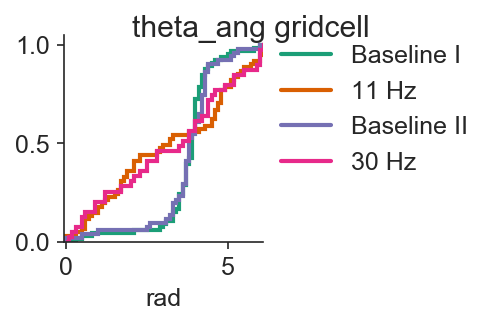

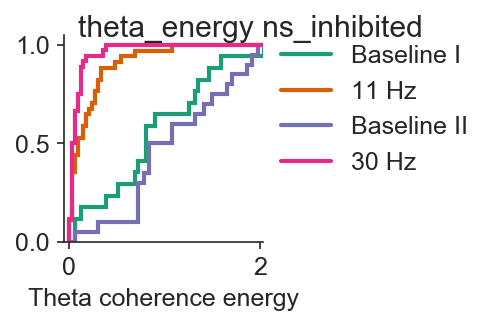

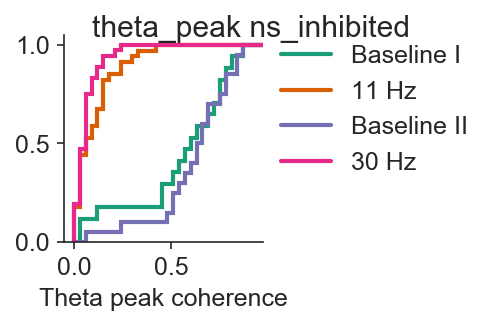

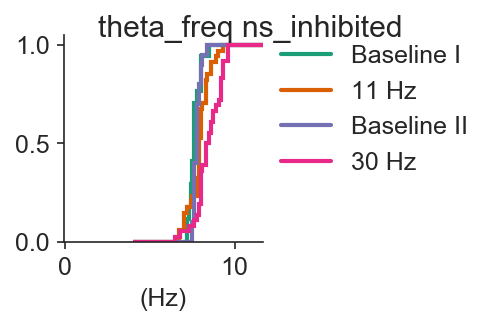

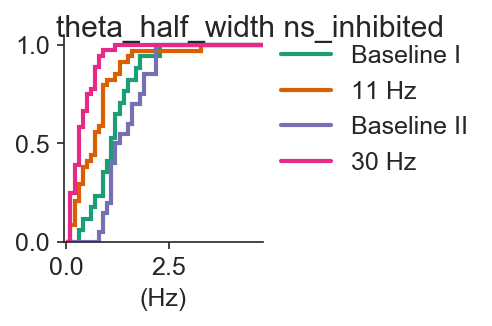

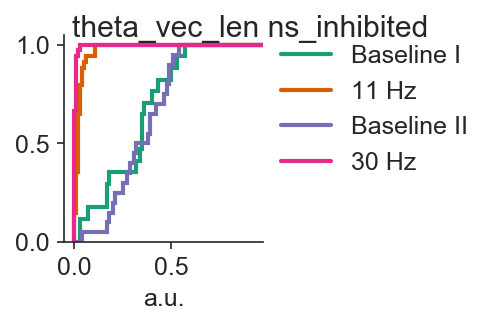

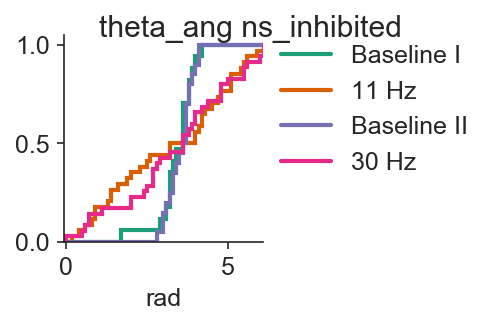

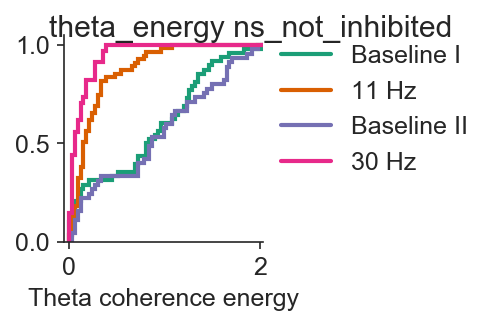

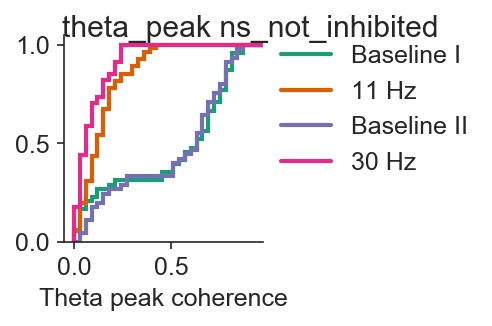

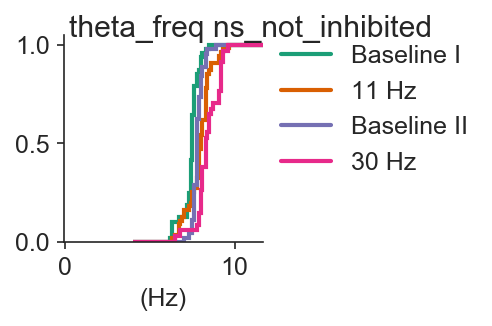

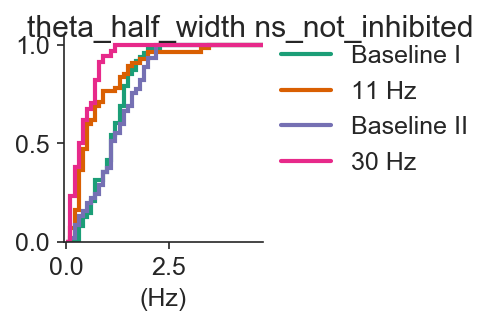

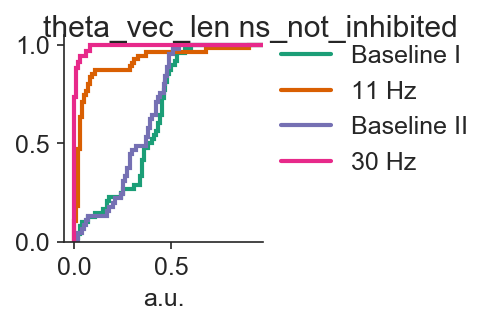

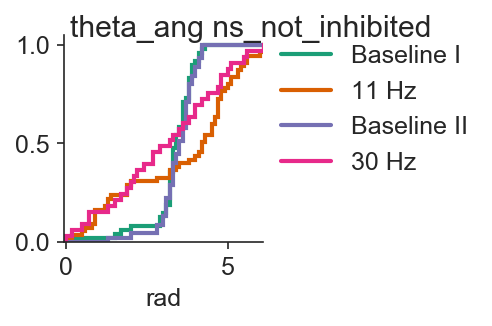

In [26]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'theta_energy': np.arange(0, 2.1, .03),
    'theta_peak': np.arange(0, 1, .03),
    'theta_freq': np.arange(4, 12, .1),
    'theta_half_width': np.arange(0, 5, .1),
    'theta_vec_len': np.arange(0, 1, .01),
    'theta_ang': np.arange(0, 2*np.pi, .1)
}
xlabel = {
    'theta_energy': 'Theta coherence energy',
    'theta_peak': 'Theta peak coherence',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
    'theta_vec_len': 'a.u.',
    'theta_ang': 'rad'
}
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in bins:
        fig = plt.figure(figsize=(3.5,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            values = data.query(query + ' and ' + cell_type)[key]
            values.hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [27]:
data['stim_strength'] = data.stim_p_max / data.theta_peak

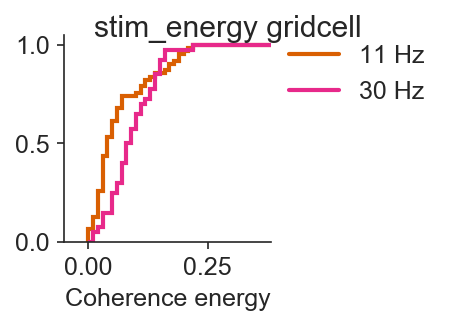

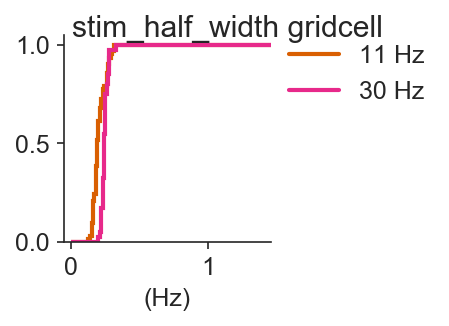

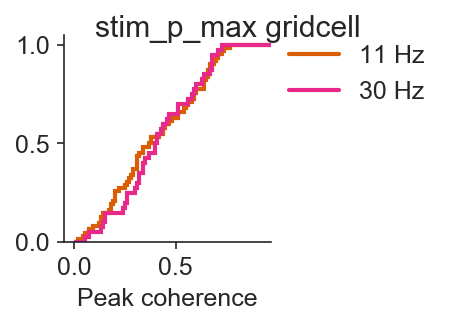

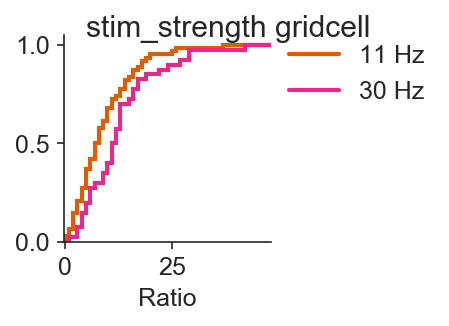

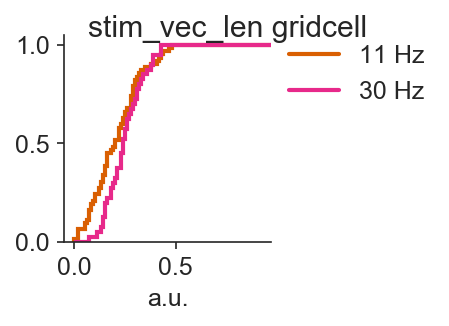

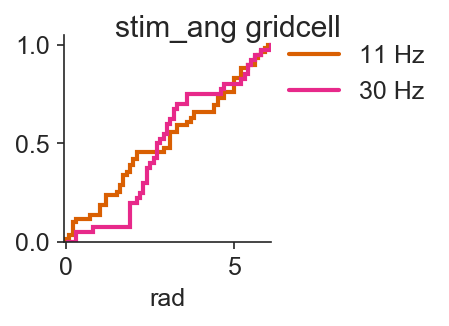

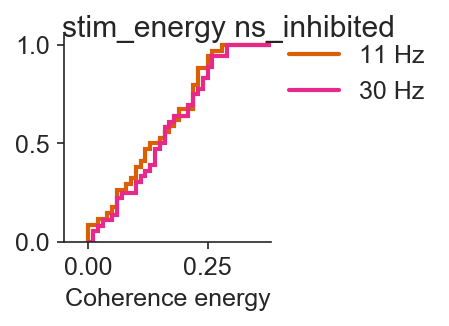

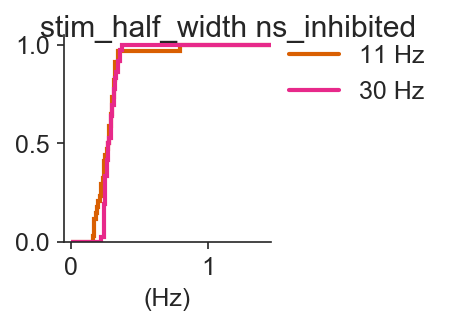

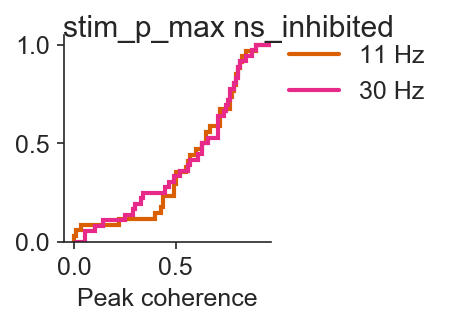

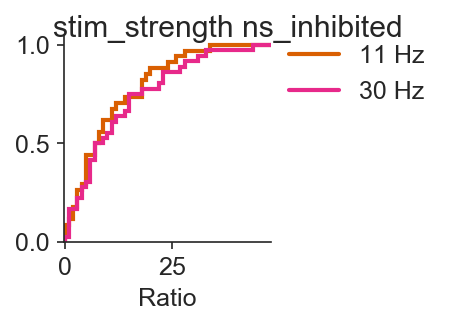

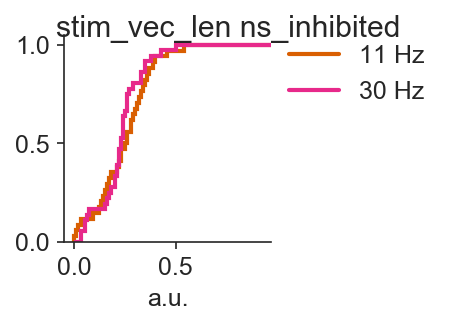

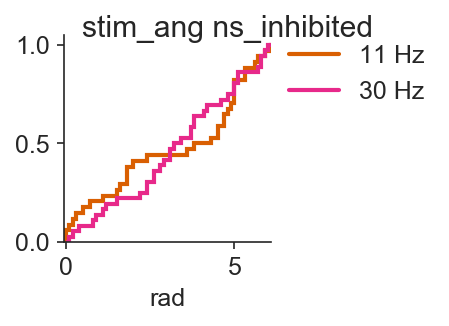

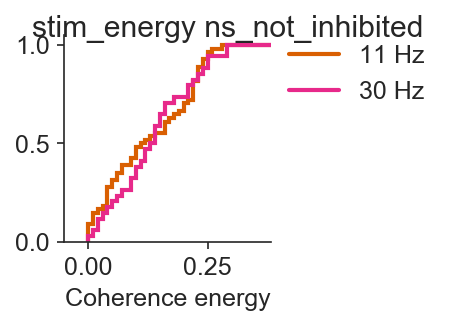

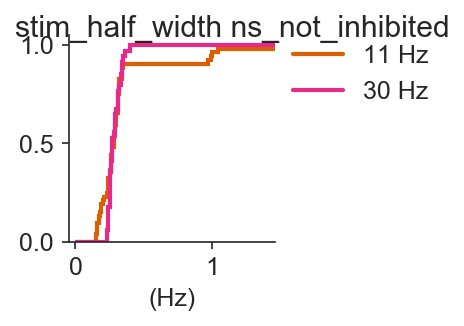

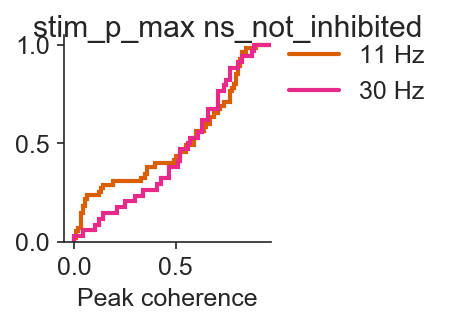

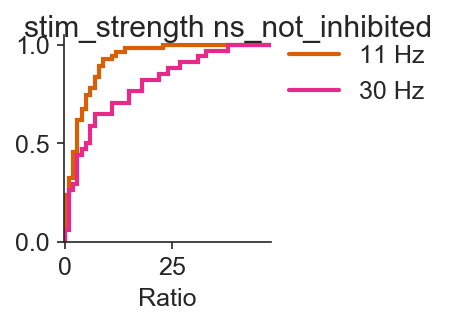

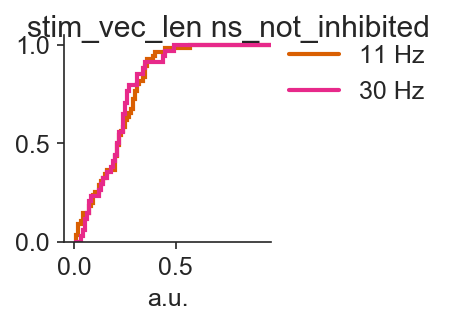

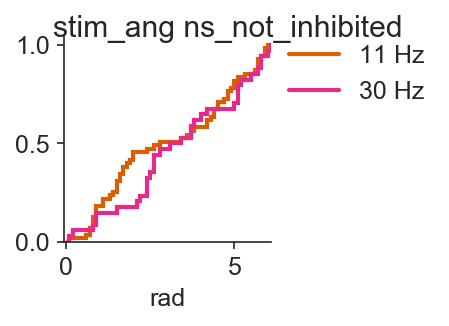

In [28]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'stim_energy': np.arange(0, .4, .01),
    'stim_half_width': np.arange(0, 1.5, .01),
    'stim_p_max': np.arange(0, 1, .01),
    'stim_strength': np.arange(0, 50, 1),
    'stim_vec_len': np.arange(0,1,0.01),
    'stim_ang': np.arange(0, 2*np.pi, .1)
}
xlabel = {
    'stim_energy': 'Coherence energy',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak coherence',
    'stim_strength': 'Ratio',
    'stim_vec_len': 'a.u.',
    'stim_ang': 'rad'
}
# key = 'theta_energy'
# key = 'theta_peak'
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in bins:
        fig = plt.figure(figsize=(3.2,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors[1::2], queries[1::2], labels[1::2]):
            values = data.query(query + ' and ' + cell_type)[key]
            values.hist(
                bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
                histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        plt.xlim(-0.05, bins[key].max() - bins[key].max()*0.02)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

## polar plot

In [53]:
from septum_mec.analysis.statistics import VonMisesKDE

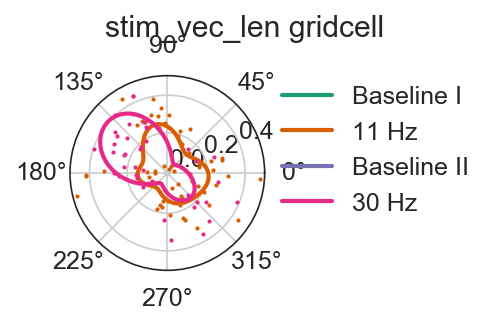

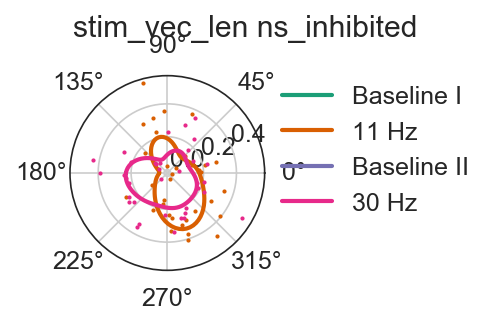

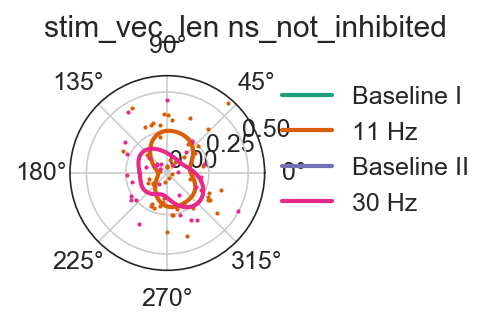

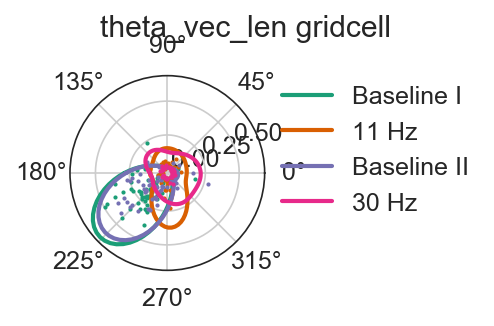

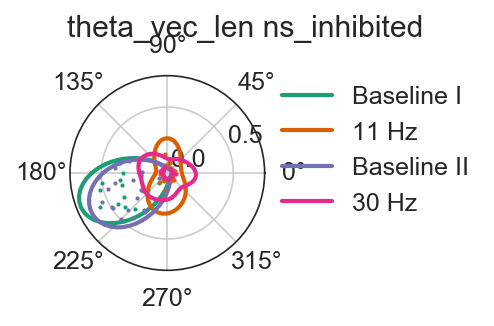

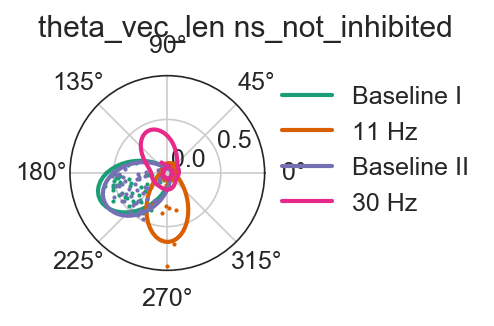

In [77]:
for paradigm in ['stim', 'theta']:
    key = paradigm + '_vec_len'
    for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
        fig = plt.figure(figsize=(3.2,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            data_query = data.query(query + ' and ' + cell_type)
            values = data_query[key].values
            angles = data_query[paradigm + '_ang'].values
            kde = VonMisesKDE(angles, weights=values, kappa=5)
            bins = np.linspace(-np.pi, np.pi, 100)
            plt.polar(bins, kde.evaluate(bins), color=color, lw=lw)
            plt.polar(angles, values, color=color, lw=1, ls='none', marker='.', markersize=2)
#             values.hist(
#                 bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
#                 histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
#         plt.grid(False)
        figname = f'spike-lfp-polar-plot-{paradigm}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [59]:
kde.kde

<bound method VonMisesKDE.kde of <septum_mec.analysis.statistics.VonMisesKDE object at 0x7fe2f86615f8>>

# stats

In [29]:
keys = [
    'theta_energy',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'theta_vec_len',
    'theta_ang',
    'stim_energy',
    'stim_half_width',
    'stim_p_max',
    'stim_strength',
    'stim_vec_len',
    'stim_ang'
]
cell_types = [
    'gridcell', 
    'ns_inhibited', 
    'ns_not_inhibited'
]
results = {}
for cell_type in cell_types:
    results[cell_type] = {}
    for key in keys:
        results[cell_type][key] = list()
        for query, label in zip(queries, labels):
            values = data.query(query + ' and ' + cell_type).loc[:,['entity', 'unit_idnum', 'date', key]]
            results[cell_type][key].append(values.rename({key: label}, axis=1))

In [30]:
from functools import reduce

In [31]:
for cell_type, cell_type_val in results.items():
    for key, val in cell_type_val.items():
        df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'unit_idnum', 'date'], how='outer'), val)
        results[cell_type][key] = df#.drop('unit_day',axis=1)

In [32]:
results['gridcell']['theta_energy']

,entity,unit_idnum,date,Baseline I,11 Hz,Baseline II,30 Hz
0,1833,30,260619,0.416880,NaN,0.305551,NaN
1,1833,31,260619,0.162091,NaN,0.144844,0.052280
2,1833,32,260619,0.102249,0.026332,0.066668,0.029473
3,1833,78,260619,0.514819,NaN,NaN,NaN
4,1833,79,260619,0.384774,0.074517,NaN,NaN
...,...,...,...,...,...,...,...
146,1833,249,120619,NaN,NaN,NaN,0.052303
147,1833,218,290519,NaN,NaN,NaN,0.084276
148,1833,106,60619,NaN,NaN,NaN,0.042799
149,1833,168,60619,NaN,NaN,NaN,0.033346


In [33]:
# var = results['gridcell']['theta_energy']

In [34]:
# baseline_i = [var.query(f'entity=="{entity}"').loc[:,'Baseline I'].rename(entity).dropna().values for entity in var.entity.unique()]
# stim_11 = [var.query(f'entity=="{entity}"').loc[:,'11 Hz'].rename(entity).dropna().values for entity in var.entity.unique()]

In [35]:
# boot_baseline_i = block_bootstrap(baseline_i, n_boots=1000, statistic=np.mean)
# boot_stim_11 = block_bootstrap(stim_11, n_boots=1000, statistic=np.mean)
# pval, observed_diff = permutation_resampling(np.ravel(boot_cases), np.ravel(boot_controls), n_samples=1000, statistic=np.mean)
    
#     Uvalue, pval = scipy.stats.mannwhitneyu(
#         np.ravel(boot_cases), 
#         np.ravel(boot_controls),
#         alternative='two-sided')

#     boot_cases = block_bootstrap(case, n_boots=n_boots, statistic=statistic)
#     boot_controls = block_bootstrap(control, n_boots=n_boots, statistic=statistic)
#     pval, observed_diff = compute_direct_prob(np.ravel(boot_cases), np.ravel(boot_controls))

In [36]:
# TODO
# eksempel polarplot av phase precessing celle
# populasjon vector length tall test
# cumulative vector length plot bytter ut coherence peak
# ta vekk baseline i vs 30 hz violin plot

In [85]:
bootstrap_results = {}
for cell_type in results:
    bootstrap_results[cell_type] = {}
    for key, df in results[cell_type].items():
        bootstrap_results[cell_type][key] = pd.DataFrame()
        group = df.groupby('entity')
        for label in labels:
            entity_values = np.array([d.loc[:, label].dropna().values for _, d in group if d.loc[:, label].count() > 0])
            if len([i for j in entity_values for i in j]) < 3: # less than total 3 samples
                boot_samples = np.ones(100) * np.nan
            else:
                boot_samples = block_bootstrap(entity_values, n_boots=100, n_samples=10, n_blocks=4, statistic=np.mean)
            bootstrap_results[cell_type][key].loc[:, label] = np.ravel(boot_samples)

In [86]:
bootstrap_results['gridcell']['theta_energy']

,Baseline I,11 Hz,Baseline II,30 Hz
0,0.185308,0.062044,0.516485,0.034407
1,0.131058,0.101871,0.128984,0.045612
2,0.161632,0.124483,0.483468,0.037541
3,0.174530,0.050406,0.275506,0.046919
4,0.228065,0.055830,0.389961,0.047416
...,...,...,...,...
95,0.192283,0.083370,0.128842,0.046263
96,0.130118,0.178513,0.315984,0.040918
97,0.161951,0.128790,0.234307,0.039134
98,0.216102,0.105508,0.355116,0.062004


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe2f10c0048>,
      dtype=object)

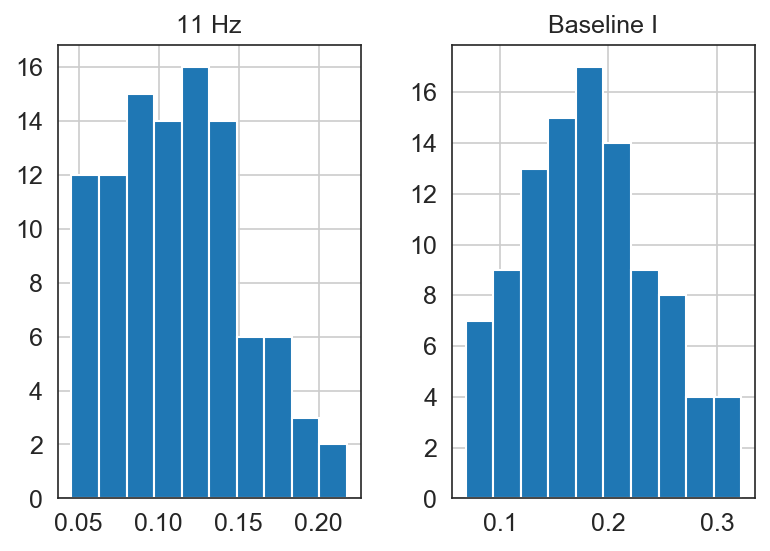

In [87]:
bootstrap_results['gridcell']['theta_energy'].loc[:,['Baseline I', '11 Hz']].hist()

In [88]:
def compute_weighted_mean_sem(data, label):
    group = data.groupby('entity')
    tmp = [d.loc[:, label].dropna().values for _, d in group]
    values = np.concatenate(tmp)
    if len(values) == 0:
        return [np.nan] * 3
    weights = np.concatenate([np.ones_like(a) / len(a) for a in tmp])
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average)**2, weights=weights)
    sem = np.sqrt(variance / len(values))
    return average, sem, len(values)


def compute_confidence_interval(data, alpha=0.05):
    stat = np.sort(data.dropna())
    n = len(stat)
    if n == 0:
        return np.nan, np.nan
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
#     low, high = np.percentile(data.dropna(), [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def pvalue(df, df_bootstrap, control_key, case_key):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    low, high = compute_confidence_interval(case - average_control)
    
    case_shift = case - case.mean()
    diff = abs(average_case - average_control)    
    
    pval = (np.sum(case_shift > diff) + np.sum(case_shift < - diff)) / n
    
    return "{:.1e} [{:.2f}, {:.2f}]".format(pval, low, high)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [89]:
stats = {}
for cell_type in bootstrap_results:
    stat = pd.DataFrame()

    for key, df in bootstrap_results[cell_type].items():
        Key = rename(key)
        
        for label in labels:
#             low, high = compute_confidence_interval(df.loc[:,label])
#             average, _, n = compute_weighted_mean_sem(results[cell_type][key], label)
#             stat.loc[label, Key] = "{:.2f} [{:.2f}, {:.2f}] ({})".format(average, low, high, n)
            average, sem, n = compute_weighted_mean_sem(results[cell_type][key], label)
            if np.isnan(average):
                stat.loc[label, Key] = np.nan
            else:
                stat.loc[label, Key] = "{:.2f} ± {:.2f} ({})".format(average, sem, n)

        for i, c1 in enumerate(df.columns):
            for c2 in df.columns[i+1:]:
                stat.loc[f'{c1} - {c2}', Key] = pvalue(results[cell_type][key], df, c1, c2)

    stats[cell_type] = stat

In [90]:
stats['gridcell']

,Theta energy,Theta peak,Theta freq,Theta half width,Theta vec len,Theta ang,Stim energy,Stim half width,Stim p max,Stim strength,Stim vec len,Stim ang
Baseline I,0.20 ± 0.03 (66),0.17 ± 0.02 (66),7.74 ± 0.07 (66),0.63 ± 0.04 (66),0.19 ± 0.01 (66),3.74 ± 0.10 (66),NaN,NaN,NaN,NaN,NaN,NaN
11 Hz,0.12 ± 0.02 (62),0.08 ± 0.01 (62),7.77 ± 0.12 (62),0.48 ± 0.08 (62),0.04 ± 0.00 (62),3.17 ± 0.24 (62),0.09 ± 0.01 (62),0.22 ± 0.01 (62),0.44 ± 0.03 (62),8.70 ± 0.87 (62),0.21 ± 0.02 (62),2.86 ± 0.25 (62)
Baseline II,0.36 ± 0.04 (51),0.26 ± 0.03 (51),8.13 ± 0.04 (51),0.83 ± 0.06 (51),0.23 ± 0.02 (51),3.94 ± 0.10 (51),NaN,NaN,NaN,NaN,NaN,NaN
30 Hz,0.04 ± 0.00 (40),0.04 ± 0.00 (40),7.95 ± 0.18 (40),0.30 ± 0.02 (40),0.02 ± 0.00 (40),3.77 ± 0.29 (40),0.09 ± 0.01 (40),0.25 ± 0.00 (40),0.40 ± 0.03 (40),12.38 ± 1.29 (40),0.25 ± 0.01 (40),2.69 ± 0.23 (40)
Baseline I - 11 Hz,"3.0e-02 [-0.15, -0.00]","0.0e+00 [-0.13, -0.04]","9.2e-01 [-0.53, 0.71]","2.6e-01 [-0.36, 0.19]","0.0e+00 [-0.17, -0.14]","7.0e-02 [-1.13, 0.12]",NaN,NaN,NaN,NaN,NaN,NaN
Baseline I - Baseline II,"1.8e-01 [-0.07, 0.43]","1.5e-01 [-0.06, 0.24]","0.0e+00 [0.16, 0.56]","3.1e-01 [-0.14, 0.60]","4.8e-01 [-0.06, 0.16]","3.6e-01 [-0.13, 0.58]",NaN,NaN,NaN,NaN,NaN,NaN
Baseline I - 30 Hz,"0.0e+00 [-0.17, -0.14]","0.0e+00 [-0.14, -0.11]","4.6e-01 [-0.34, 0.74]","0.0e+00 [-0.41, -0.21]","0.0e+00 [-0.18, -0.17]","9.2e-01 [-0.77, 0.75]",NaN,NaN,NaN,NaN,NaN,NaN
11 Hz - Baseline II,"7.0e-02 [0.01, 0.51]","0.0e+00 [0.03, 0.33]","0.0e+00 [0.13, 0.54]","7.0e-02 [0.01, 0.75]","0.0e+00 [0.10, 0.32]","0.0e+00 [0.44, 1.15]",NaN,NaN,NaN,NaN,NaN,NaN
11 Hz - 30 Hz,"0.0e+00 [-0.09, -0.06]","1.0e-02 [-0.05, -0.02]","5.0e-01 [-0.37, 0.72]","0.0e+00 [-0.26, -0.06]","0.0e+00 [-0.03, -0.01]","1.7e-01 [-0.19, 1.32]","5.5e-01 [-0.01, 0.02]","0.0e+00 [0.02, 0.04]","4.1e-01 [-0.14, 0.06]","1.6e-01 [-1.62, 8.33]","1.7e-01 [-0.02, 0.08]","6.9e-01 [-0.88, 0.67]"
Baseline II - 30 Hz,"0.0e+00 [-0.33, -0.30]","0.0e+00 [-0.23, -0.20]","4.8e-01 [-0.73, 0.35]","0.0e+00 [-0.61, -0.41]","0.0e+00 [-0.22, -0.21]","6.7e-01 [-0.96, 0.55]",NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

# psd plots

In [44]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [45]:
coher = pd.read_feather(output_path / 'data' / 'coherence.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [46]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

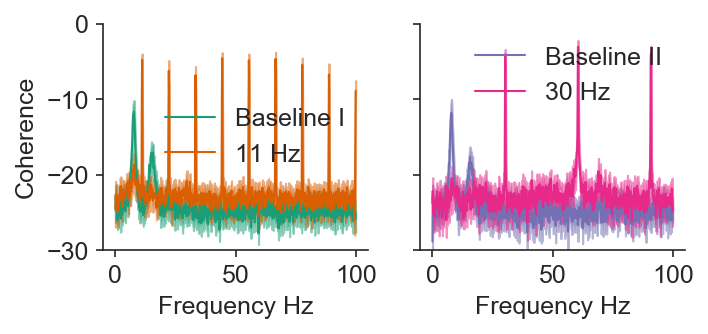

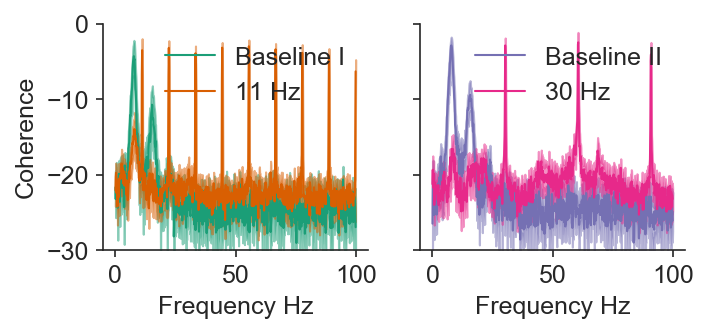

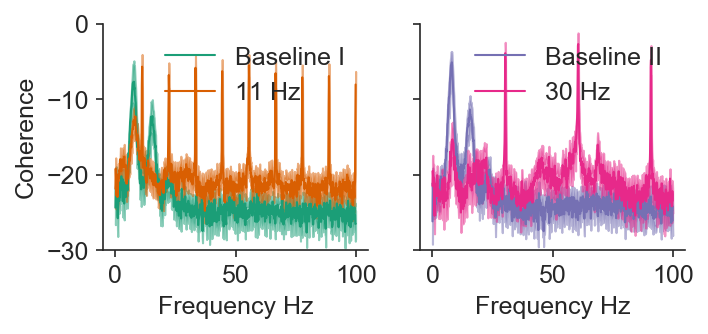

In [47]:
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
    #     ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
        ax.set_ylim(-30, 0)
    axs[0].set_ylabel('Coherence')
    despine()
    figname = f'spike-lfp-coherence-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [48]:
action = project.require_action("stimulus-spike-lfp-response" + lfp_location)

In [49]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_gridcell.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_ns_inhibited.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_gridcell.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_ns_not_inhibited.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_ns_inhibited.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/statistics_ns_not_inhibited.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/data/theta_kde.feather',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/data/stim_kde.feather',
 

In [50]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-lfp-response.ipynb")